# Numpy 一维-DFT

## 理论背景

物质在纳米尺度的物化性质必须考虑量子效应。量子力学用薛定谔方程描述物理体系，计算复杂度随电子数量快速上升。DFT大幅降低了计算量（将多电子体系的薛定谔方程转化成单电子形式KS方程，将精度损失全部归入交换关联泛函），使得数值计算纳米材料成为可能。

KS方程聚焦体系能量和电子密度的关系，二者一一对应（其他物理性质在求出这两项后可另行导出）。在量子力学中，能量与哈密顿量（算符）对应，而电子密度与波函数对应。问题归结为如何正确写出作用在体系波函数上的哈密顿量并求解KS方程

## 代码概述

- 参考文献: http://dcwww.camd.dtu.dk/~askhl/files/python-dft-exercises.pdf
- 目标: 针对谐振子，考虑动能、静电势、LDA，忽略关联项；写出这种情况下体系的KS方程并求解

根据KS方程（简化版薛定谔方程）通用形式，哈密顿量由 动能和势能 组成，而且势能包含 外部势（谐振子为$x^2$）、电子库伦势（Hartree）和电子交互关联势（用LDA势近似）

$$\hat{H}=-\frac{1}{2}\frac{d^2}{dx^2}+v(x)\\
v(x)=v_{Hartree}(x)+v_{LDA}(x)+x^2$$

接下来要将上述通用形式写成具体的数值形式，并求解方程

## 逐个击破

顺序：
- 动能
- 外势（对于谐振子，就是$x^2$）
- LDA（已有）
- 库伦

### 先数值表示动能（算符）

如何数值表示二阶微分？

二阶微分基于一阶微分，一阶导的数值表示形式：

$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$

然而我们没有网格上的具体值（求解KS方程之前未知），要想办法将算符与网格值剥离（变成向量相乘的形式），类似这样：

$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$

为此，我们可以定义一阶导算符：

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$


- 端点处的导数不好定义，暂时忽略这个不算太大的问题
- $\delta_{ij}$ 是 Kronecker delta
- 使用了爱因斯坦求和约定

In [1]:
import numpy as np

n_grid_demo=5 # 为演示简便，取较小的n_grid
x=np.linspace(-5,5,n_grid_demo)
h=x[1]-x[0]

D=(-np.eye(n_grid_demo)+np.diagflat(np.ones(n_grid_demo-1),1))/h
print(D)

[[-0.4  0.4  0.   0.   0. ]
 [ 0.  -0.4  0.4  0.   0. ]
 [ 0.   0.  -0.4  0.4  0. ]
 [ 0.   0.   0.  -0.4  0.4]
 [ 0.   0.   0.   0.  -0.4]]


同样的我们想把二阶微分算符剥离出来：

$$(\frac{d^2y}{dx^2})_{i}=D^2_{ij} y_{j}$$

二阶算符就应该表示成:

$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

它和一阶算符之间存在一些运算关系:

$$D^2_{ij}=-D_{ik}D_{jk}$$

In [2]:
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]
print(D2)

[[-0.32  0.16  0.    0.    0.  ]
 [ 0.16 -0.32  0.16  0.    0.  ]
 [ 0.    0.16 -0.32  0.16  0.  ]
 [ 0.    0.    0.16 -0.32  0.16]
 [ 0.    0.    0.    0.16 -0.32]]


采用最经典的正弦函数例子，验证上述两个算符是否正确

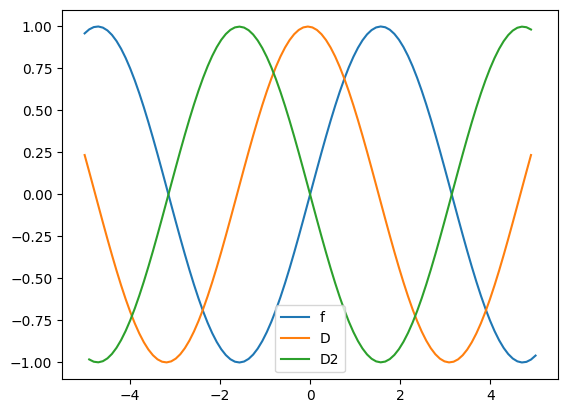

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

n_grid=100 # 为画图较平滑，取较大的n_grid
x=np.linspace(-5,5,n_grid)
h=x[1]-x[0]
D=(-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1))/h
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

y=np.sin(x)
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.legend()

可以看到结果符合三角函数的性质，将D和D2两个算符作用到函数上，确实得到了它的一阶而二阶导数

我们可以先不管势能项，试试看只有动能项的时候（自由电子）KS方程求解出来会是什么样子

注：在量子力学中，所有可观测物理量 $A$ 都有一个对应的算符 $\hat{A}$，代表作用于波函数的一种运算。

$$\hat{A} \psi = a \psi$$

$a$ 即算符本征值，$\psi$ 是算符 $A$ 的本征态。对这个本征态波函数 $\psi$ 测量可观测物理量 $A$，得到的值就是 $a$

类似的，如果想要求出体系的总能量，需要求解哈密顿算符的本征值。求出本征值的同时，本征态也会求出，对应特定状态下的波函数（我们预先并不知道体系的波函数长什么样子）。

- 不考虑电子相互作用时，体系的哈密顿量:

$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$

- 直接调用现成的线性代数求解器:

In [4]:
eig_non, psi_non=np.linalg.eigh(-D2/2)

- 求出本征值和对应的本征态后，绘图观察

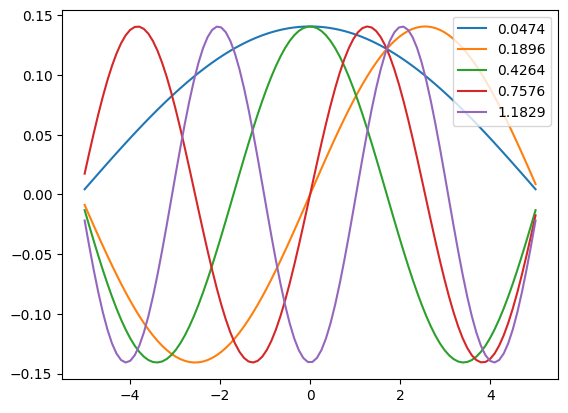

In [5]:
for i in range(5):
    plt.plot(x,psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)

所绘制的曲线反映的就是波函数（能量的本征态）的信息，而图例中写的则是对应的能量（能量的本征值）大小

后面的求解原理类似，只不过逐渐追加哈密顿算符的组分，都直接调用成熟的线性代数求解器完成本征值问题求解

### 外势

- 让我们引入外势：

$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2} + x^2$$

- 需要写成矩阵形式:

In [6]:
X=np.diagflat(x*x)
print(X)

[[25.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         24.00010203  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         23.02061014 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 23.02061014  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         24.00010203
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  25.        ]]


- 求解后绘图

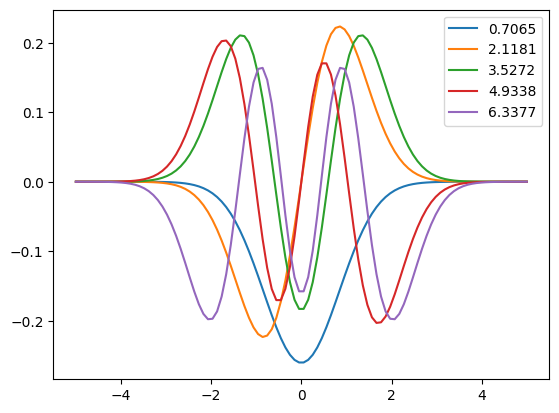

In [7]:
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)
for i in range(5):
    plt.plot(x,psi_harm[:,i], label=f"{eig_harm[i]:.4f}")
    plt.legend(loc=1)

再看一个势能阱的例子

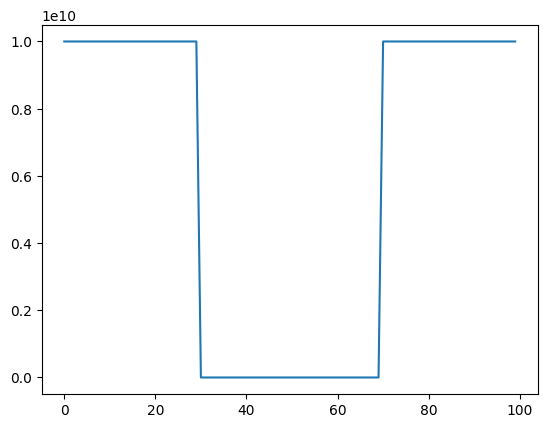

In [8]:
w=np.full_like(x,1e10)
w[np.logical_and(x>-2,x<2)]=0.
plt.plot(w)

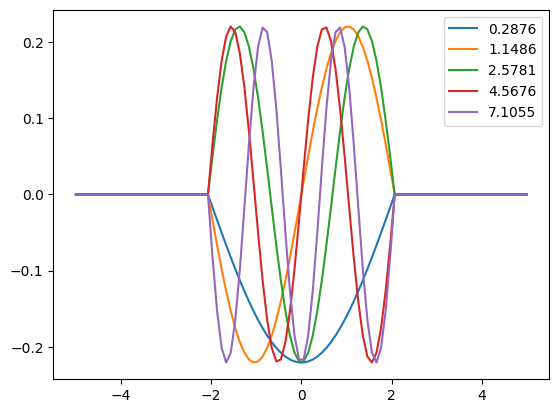

In [9]:
eig_well, psi_well= np.linalg.eigh(-D2/2+np.diagflat(w))
for i in range(5):
    plt.plot(x,psi_well[:,i], label=f"{eig_well[i]:.4f}")
    plt.legend(loc=1)

### 引入交换关联势和库伦势

多电子体系最麻烦的地方在于电子之间的相互作用，上面我们考虑了体系整体动能、外部势能，但是还没有考虑到电子之间的相互作用能。要加入这一项，我们需要先得到电子的信息——电荷密度分布，然后才能导出库仑势和交换关联势

先定义几个常用的函数
- 积分
- 波函数必须满足归一化要求:

$$\int \lvert \psi \rvert ^2 dx = 1$$


In [10]:
# 积分
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

# 归一化的波函数
def get_np(psi, x):
    # normalization
    I=integral(x,psi**2,axis=0)
    normed_psi=psi/np.sqrt(I)[None, :]
    return normed_psi

接下来可以求出电荷密度

- 定义 $f_n$ 为占据数, 电荷密度 $n(x)$ 可以写成:

$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

- 注意:
    - DFT框架下，求解的都是最低能量态（基态）
    - 每个态最多只能容纳两个电子，自旋分别向上和向下
    - 电子从低能级到高能级依次填充

In [11]:
def get_nx(num_electron, psi, x):
    normed_psi=get_np(psi,x) # 调用上面的函数将波函数归一化

    # occupation num
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # density
    nx=np.zeros_like(normed_psi[:,0])
    for ne, psi  in zip(fn,normed_psi.T):
        nx += ne*(psi**2)
    return nx

准备工作做好后，试试看随便给定n个电子，体系的电荷密度长什么样？以及外部势对此有什么影响？

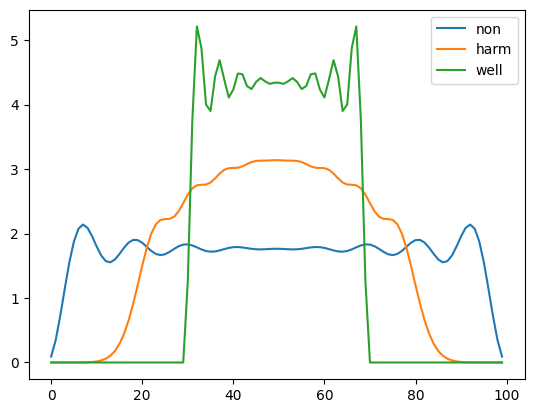

In [12]:
# number of electrons
num_electron=17

# 没有外势
plt.plot(get_nx(num_electron,psi_non, x), label="non")
# 外势为x^2
plt.plot(get_nx(num_electron,psi_harm, x), label="harm")
# 外势为无限深势阱
plt.plot(get_nx(num_electron,psi_well, x), label="well")
# 打上标签
plt.legend(loc=1)

有了电荷密度，就可以根据理论公式，写出电荷密度泛函项

#### 交换能的贡献（忽略关联势）

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- 交换势是能量的导数:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$


#### 库仑势的贡献（简化版）

$$ E_{Ha}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

其中 $\varepsilon$ 是一个小正数

- 库伦势:
$$ v_{Ha}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- 统一写成矩阵形式
$$E_{Ha} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Ha, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

In [13]:
def get_exchange(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

## 激动人心的最终boss

将上述所有项目加到一起，开始自洽求解电荷密度、本征态等

流程：
1. 随便猜一个电荷密度分布
2. 计算泛函项（交换关联势和库仑势）
3. 把它们加入哈密顿量
4. 求出哈密顿量的本征值和对应的本征态
5. 根据本征态积分出电荷密度，与猜测的对比，如果差别很大，重复这个流程

In [14]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

max_iter=1000
energy_tolerance=1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

# 1
nx=np.zeros(n_grid)

for i in range(max_iter):
    # 2
    ex_energy, ex_potential=get_exchange(nx,x)
    ha_energy, ha_potential=get_hatree(nx,x)
    
    # 3
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    # 4
    energy, psi= np.linalg.eigh(H)
    
    # 5
    ## 记录
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    ## 检查是否收敛
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    ## 更新电荷密度分布
    nx=get_nx(num_electron,psi,x)
    ## 也可以用beta参数混合新旧电荷密度，加速收敛
    # beta=0.1
    # nx=beta*get_nx(num_electron,psi,x) + (1-beta)*nx
    
else:
    print("not converged")

step: 0     energy: 0.7065     energy_diff: -inf
step: 1     energy: 16.4038    energy_diff: 15.6973788278
step: 2     energy: 13.7926    energy_diff: -2.6112924521
step: 3     energy: 15.3405    energy_diff: 1.5479703556
step: 4     energy: 14.4113    energy_diff: -0.9292702915
step: 5     energy: 14.9781    energy_diff: 0.5668366593
step: 6     energy: 14.6318    energy_diff: -0.3463073772
step: 7     energy: 14.8446    energy_diff: 0.2128634653
step: 8     energy: 14.7137    energy_diff: -0.1309686776
step: 9     energy: 14.7944    energy_diff: 0.0807523360
step: 10    energy: 14.7446    energy_diff: -0.0498086653
step: 11    energy: 14.7754    energy_diff: 0.0307449491
step: 12    energy: 14.7564    energy_diff: -0.0189798445
step: 13    energy: 14.7681    energy_diff: 0.0117198345
step: 14    energy: 14.7609    energy_diff: -0.0072370812
step: 15    energy: 14.7653    energy_diff: 0.0044693386
step: 16    energy: 14.7626    energy_diff: -0.0027601064
step: 17    energy: 14.7643   

求解完成！让我们看看这个简单体系的本征值和本征态长什么样？

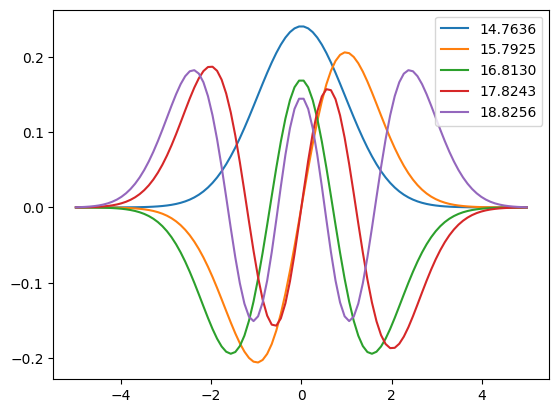

In [15]:
for i in range(5):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

看起来还不错，那么电荷密度分布呢？与前面只有动能项的那个比较一下

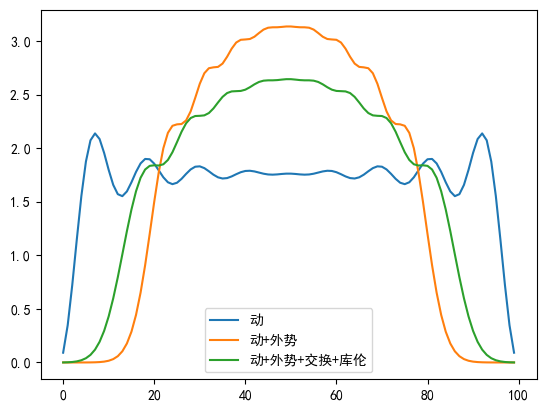

In [16]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.plot(get_nx(num_electron,psi_non,x), label="动")
plt.plot(get_nx(num_electron,psi_harm,x), label="动+外势")
plt.plot(nx, label="动+外势+交换+库伦")
plt.legend()